In [17]:
# basic libs
import sys
import time
import logging
import yaml

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# data preparation
from replay.utils import convert2spark
from replay.session_handler import get_spark_session, State, logger_with_settings
from replay.splitters import UserSplitter


In [4]:
spark = get_spark_session()
state = State(spark)
spark.conf.set("spark.local.dir", "/home/baurzhan/tmp")
display(spark.sparkContext.getConf().getAll())


[('spark.app.startTime', '1658334196001'),
 ('spark.local.dir', '/home/baurzhan/tmp'),
 ('spark.sql.shuffle.partitions', '36'),
 ('spark.app.id', 'local-1658334196585'),
 ('spark.driver.port', '45811'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.host', 'localhost'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.driver.bindAddress', '127.0.0.1'),
 ('spark.driver.extraJavaOptions',
  '-Dio.netty.tryReflectionSetAccessible=true'),
 ('spark.driver.memory', '66g'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.sql.warehouse.dir',
  'file:/home/baurzhan/model_comparison/spark-warehouse'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.kryoserializer.buffer.max', '256m'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.sql.execution.arrow.pyspark.enabled', 'true'),
 ('spark.driver.maxResultSize', '4g')]

In [5]:
data_path = lambda x: f"data/{x}/"
TRAIN_FILE_NAME = "train.csv"
TEST_FILE_NAME = "test.csv"
VAL_FILE_NAME = "val.csv"

k = 10
shuffle = False
budget = 10
trials_num = 10
seed = 1909


In [6]:
def load_data(data_path, train_file_name, val_file_name, test_file_name):
    return (
        pd.read_csv(f"{data_path}{train_file_name}"),
        pd.read_csv(f"{data_path}{val_file_name}"),
        pd.read_csv(f"{data_path}{test_file_name}"),
    )


In [27]:
def dataset_check(dataset_name):
    train_, val_, test_ = load_data(
        data_path=data_path(dataset_name),
        train_file_name=TRAIN_FILE_NAME,
        val_file_name=VAL_FILE_NAME,
        test_file_name=TEST_FILE_NAME,
    )
    train, val, test = (
        convert2spark(train_),
        convert2spark(val_),
        convert2spark(test_),
    )

    train_count = train.count()
    val_count = val.count()
    test_count = test.count()

    train_user_count = train.select("user_idx").distinct().count()
    train_item_count = train.select("item_idx").distinct().count()

    val_user_count = val.select("user_idx").distinct().count()
    val_item_count = val.select("item_idx").distinct().count()

    test_user_count = test.select("user_idx").distinct().count()
    test_item_count = test.select("item_idx").distinct().count()

    print(f"{dataset_name} dataset")
    print()
    print(f"train size:\t{train_count}")
    print(f"val size:\t{val_count}")
    print(f"test size:\t{test_count}")

    print()
    print(f"train user count:\t{train_user_count}")
    print(f"train item count:\t{train_item_count}")

    print()
    print(f"val user count:\t{val_user_count}")
    print(f"val item count:\t{val_item_count}")

    print()
    print(f"test user count:\t{test_user_count}")
    print(f"test item count:\t{test_item_count}")

    print()
    print(
        f"train data sparsity:\t{train_count / (train_user_count * train_item_count)}"
    )
    print(f"val data sparsity:\t{val_count / (val_user_count * train_item_count)}")
    print(f"train data sparsity:\t{train_count / (test_user_count * train_item_count)}")

    train_group = train_.groupby("user_idx")
    train_group_count = train_group.count()

    val_group = val_.groupby("user_idx")
    val_group_count = val_group.count()

    test_group = test_.groupby("user_idx")
    test_group_count = test_group.count()

    f, axs = plt.subplots(1, 3)
    f.set_size_inches((15 * 3, 9))
    sns.histplot(train_group_count.relevance, ax=axs[0])
    sns.histplot(val_group_count.relevance, ax=axs[1])
    sns.histplot(test_group_count.relevance, ax=axs[2])
    f.show()


22/07/20 18:11:10 WARN TaskSetManager: Stage 24 contains a task of very large size (12030 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 18:11:10 WARN TaskSetManager: Stage 30 contains a task of very large size (12030 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 18:11:11 WARN TaskSetManager: Stage 33 contains a task of very large size (12030 KiB). The maximum recommended task size is 1000 KiB.


anime dataset

train size:	4617807
val size:	110000
test size:	110000

train user count:	49486
train item count:	8558

val user count:	11000
val item count:	4551

test user count:	11000
test item count:	4659

train data sparsity:	0.010903882045308453
val data sparsity:	0.0011684973124561813
train data sparsity:	0.049053591535830374


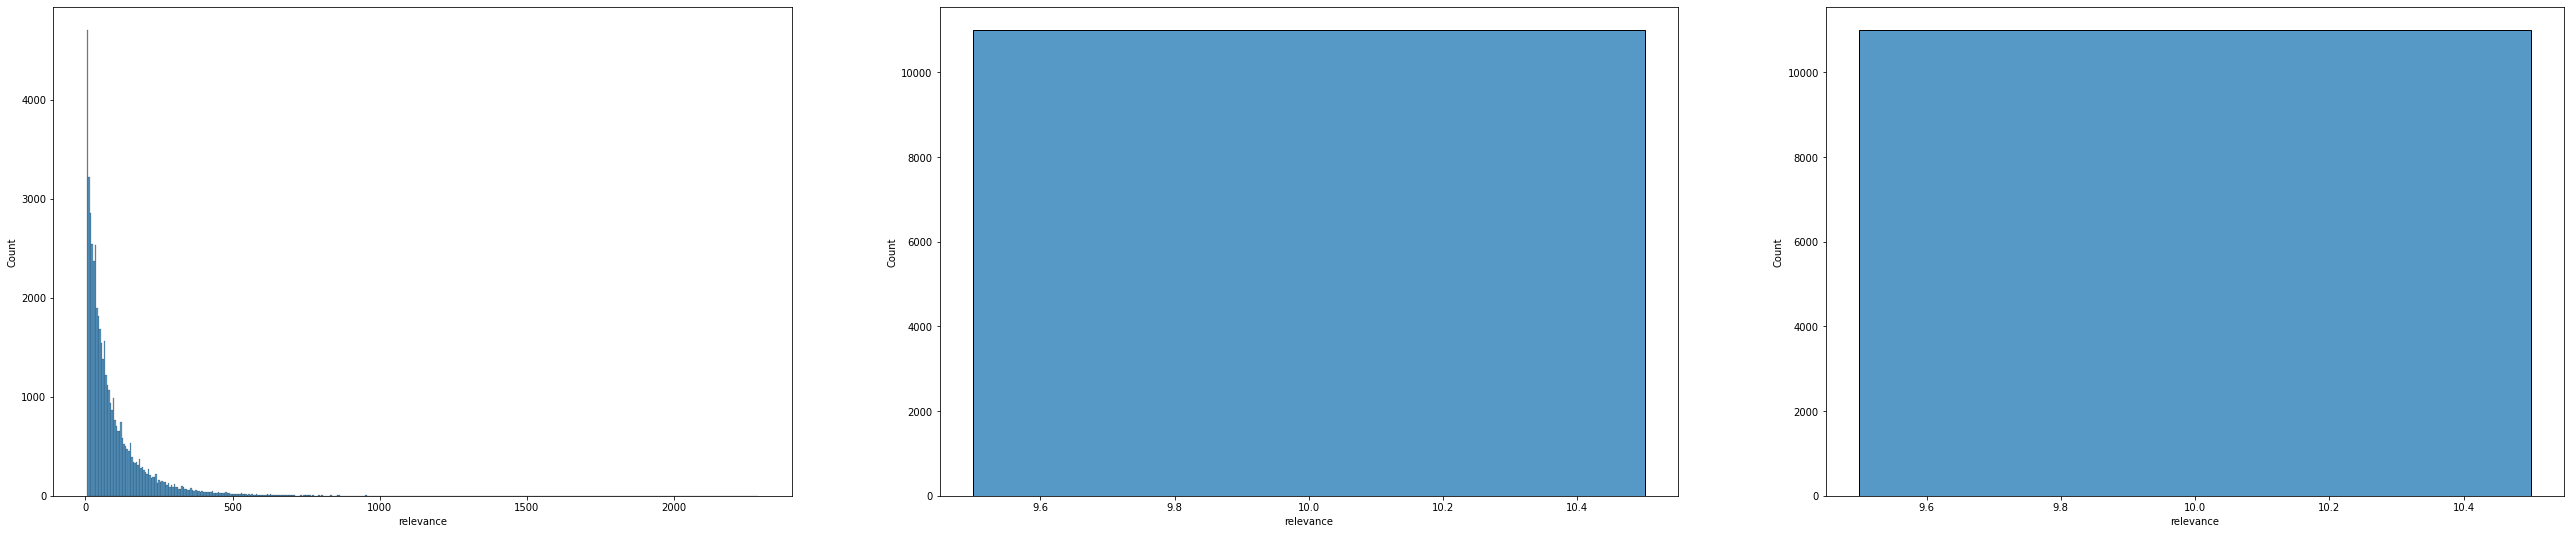

In [28]:
dataset_check("anime")


22/07/20 18:13:18 WARN TaskSetManager: Stage 96 contains a task of very large size (1564 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 18:13:19 WARN TaskSetManager: Stage 102 contains a task of very large size (1564 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 18:13:19 WARN TaskSetManager: Stage 105 contains a task of very large size (1564 KiB). The maximum recommended task size is 1000 KiB.


bookcrossing dataset

train size:	598808
val size:	19091
test size:	19096

train user count:	6562
train item count:	214354

val user count:	3138
val item count:	12554

test user count:	3138
test item count:	12443

train data sparsity:	0.0004257158066113191
val data sparsity:	2.838207518779966e-05
train data sparsity:	0.0008902317154185711


(0.0, 250.0)

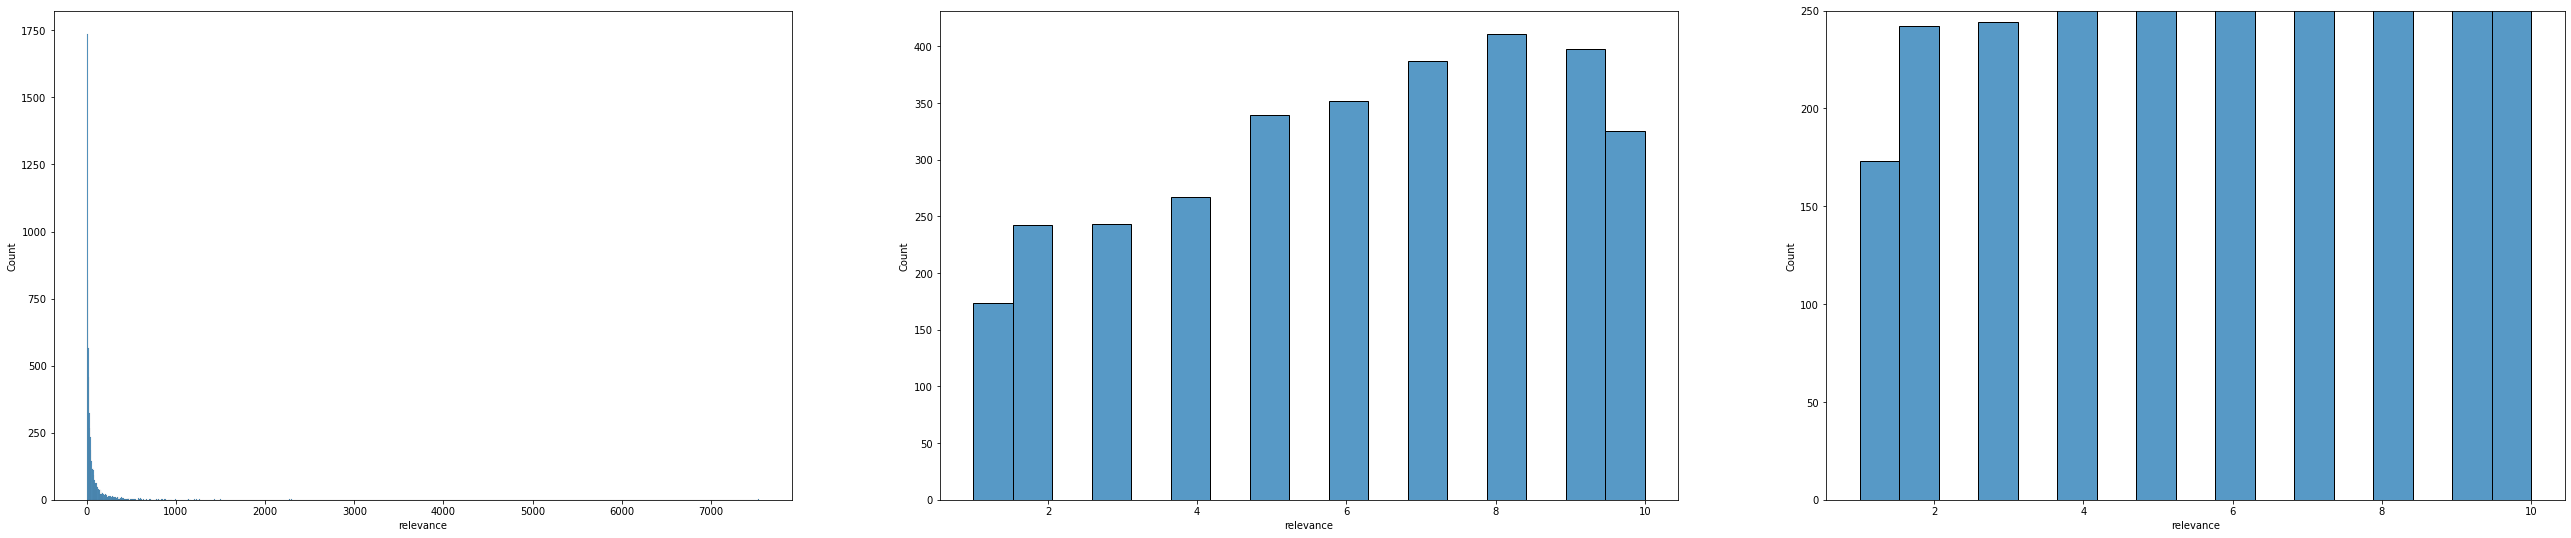

In [31]:
dataset_check("bookcrossing")


22/07/20 18:11:42 WARN TaskSetManager: Stage 72 contains a task of very large size (36240 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 18:11:42 WARN TaskSetManager: Stage 78 contains a task of very large size (36240 KiB). The maximum recommended task size is 1000 KiB.
22/07/20 18:11:43 WARN TaskSetManager: Stage 81 contains a task of very large size (36240 KiB). The maximum recommended task size is 1000 KiB.


lastfm dataset

train size:	13914378
val size:	110000
test size:	110000

train user count:	356572
train item count:	252614

val user count:	11000
val item count:	26303

test user count:	11000
test item count:	26239

train data sparsity:	0.00015447533460247236
val data sparsity:	3.958608786528063e-05
train data sparsity:	0.005007416273624797


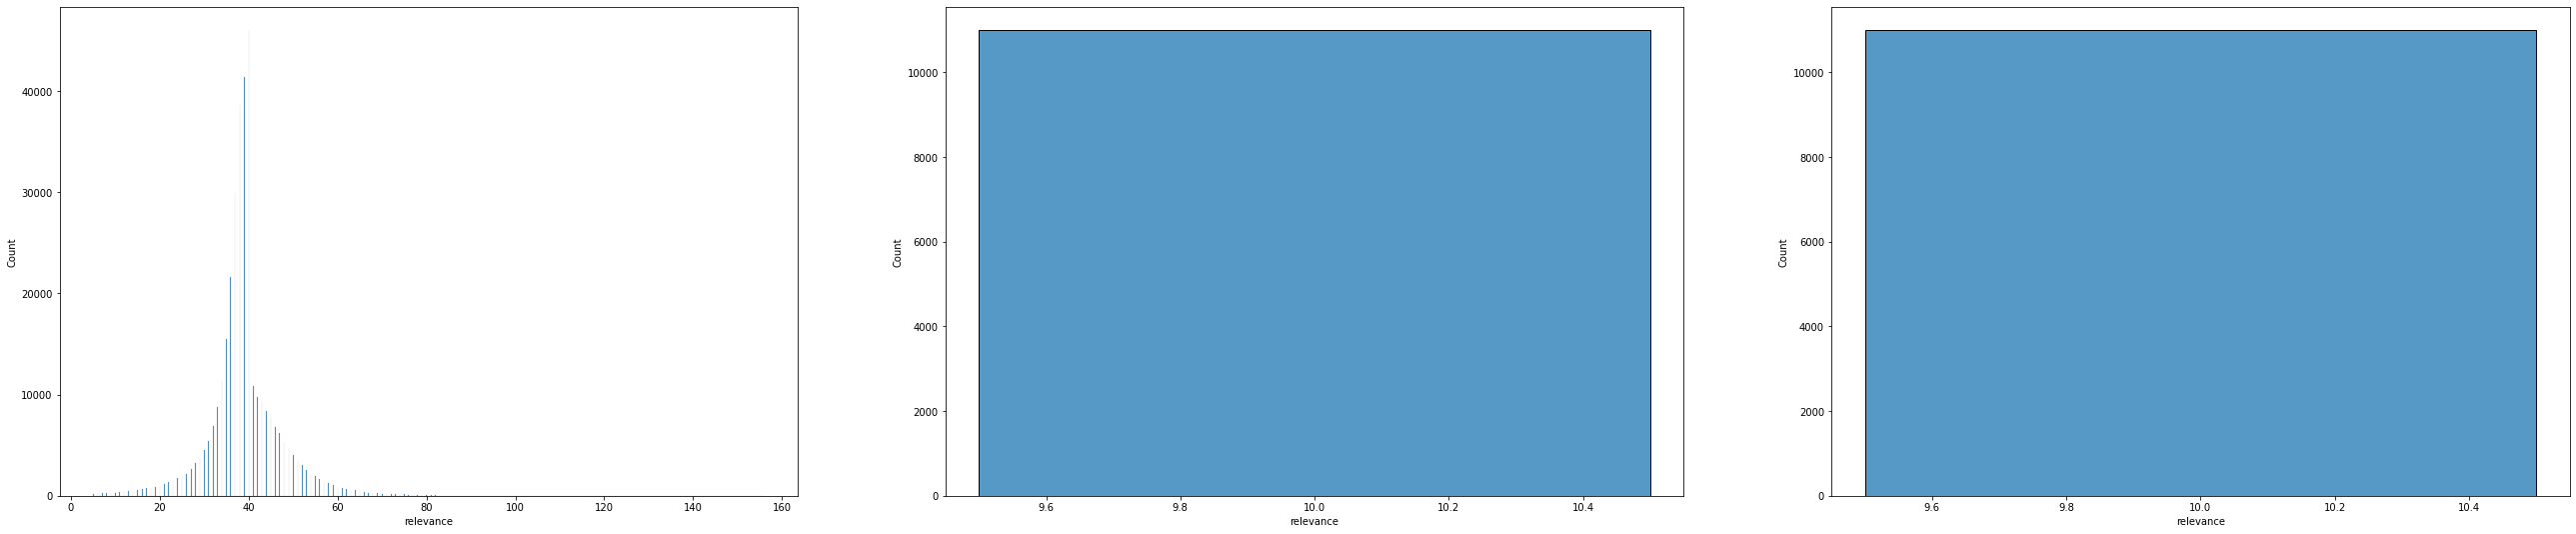

In [30]:
dataset_check("lastfm")
